This notebook takes the output of make_dataset_w_feature.ipynb and trains an xgboost regressor model

In [27]:
# data
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt


# modelling
from voyagerOne import learn # private library for learning, not explicitly needed
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import xgboost as xgb

# utils
from datetime import datetime, timedelta
import pickle

import warnings
# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_pickle('data/by_day_weather.pkl')

# day of week
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['date'] = pd.to_datetime(df['date'])
df['dow'] = df['date'].dt.dayofweek
df['dom'] = df['date'].dt.day

# holidays
cal = calendar()
holidays = cal.holidays(start=df['date'].min(), end=df['date'].max())
df['hol'] = df['date'].isin(holidays)

# add previous day as feature
df['prev_count'] = df['counts'].shift(1)
# drop the first row
df = df.dropna()
df['prev_count'] = df['prev_count'].astype(int)
 
df.head()

,date,counts,awnd,prcp,snow,snwd,tavg,tmax,tmin,dew,...,real_feel,day_real_feel,wind,day_wind,year,month,dow,dom,hol,prev_count
1,2014-01-02,2592,18.8,0.18,3.4,0.0,29.0,32.0,18.0,20.025000,...,15.595833,15.844444,14.795833,16.533333,2014,1,3,2,False,2349
2,2014-01-03,589,18.1,0.25,4.5,7.1,17.0,19.0,10.0,1.708333,...,-3.170833,-1.566667,15.866667,16.522222,2014,1,4,3,False,2592
3,2014-01-04,886,6.0,0.00,0.0,7.9,16.0,28.0,9.0,1.208333,...,0.275000,3.800000,5.550000,5.277778,2014,1,5,4,False,589
4,2014-01-05,1018,5.8,0.10,0.0,3.9,29.0,50.0,25.0,21.820833,...,18.175000,21.900000,6.250000,3.555556,2014,1,6,5,False,886
5,2014-01-06,2998,17.0,0.31,0.0,0.0,45.0,53.0,20.0,39.470833,...,34.404167,37.288889,15.366667,13.822222,2014,1,0,6,False,1018


## test an array of regressors

In [3]:
# withold Jan 2023 and Aug 2023 from all training and validation
month1_to_withold = (df['date'].dt.year==2023) & (df['date'].dt.month==8)
month2_to_withold = (df['date'].dt.year==2023) & (df['date'].dt.month==1)
withhold_range = month1_to_withold | month2_to_withold

# create X and y for training and validation
X = df.drop(columns=['date',
                    'counts', 
                    'tavg', 
                    'snwd', 
                    'day_tmin', 
                    'is_day', 
                    'precip',
                    'dew',
                    'day_dew',
                    'real_feel',
                    'snow',
                    'awnd',
                    'wind',
                    ]).loc[~withhold_range]

y = df.loc[~withhold_range, 'counts']

# create train and val sets
X_train, X_val, y_train, y_test = train_test_split(X, y.to_numpy().ravel(), test_size=0.3)

In [709]:
# test array of regressors
results = learn.test_regressors(X_train, X_val, y_train, y_test, cb=False)

Testing beginning...
Beginning RandomForest...
RandomForest accuracy: 1886.79
Beginning XGBoost...
XGBoost accuracy: 1825.62
Beginning KNN...
KNN accuracy: 3718.89
Beginning LinearRegression...
LinearRegression accuracy: 2460.35
Beginning SVR...
SVR accuracy: 6932.19
Testing Complete.


## train xgboost

In [37]:
# initialize the XGBoost model for regression:
model = xgb.XGBRegressor(
    learning_rate=0.005,
    n_estimators=2200,
    max_depth=5,
    eval_metric='mae',
    subsample=0.3,
    colsample_bytree=0.7,
    verbosity=1 
)

# fit model
model.fit(X_train, y_train)

# predict on validation set
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)


# Calculate the mean absolute error (MAE)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_val = mean_absolute_error(y_test, y_pred_val)
print(f"Mean Absolute Error Train: {mae_train}")
print(f"Mean Absolute Error Test: {mae_val}")

Mean Absolute Error Train: 998.6807390069432
Mean Absolute Error Test: 1567.8659245642957


In [38]:
# build a df with validation results
val_df = df.loc[X_val.index]
val_df['y_pred'] = y_pred_val
val_df['error'] = abs(val_df['y_pred'] - val_df['counts'])
val_df['perc_error'] = val_df['error'] / val_df['counts']
val_df['perc_error'].mean() # calculate average mape

0.13535078893739685

In [39]:
# get feature importances
pd.DataFrame({'param': X.columns, 'imp':model.feature_importances_}).sort_values(by='imp', ascending=False)

,param,imp
1,tmax,0.284766
5,day_real_feel,0.157308
12,prev_count,0.102187
4,day_precip,0.088876
2,tmin,0.075846
0,prcp,0.064539
3,rad,0.056607
7,year,0.045186
9,dow,0.038522
11,hol,0.032896


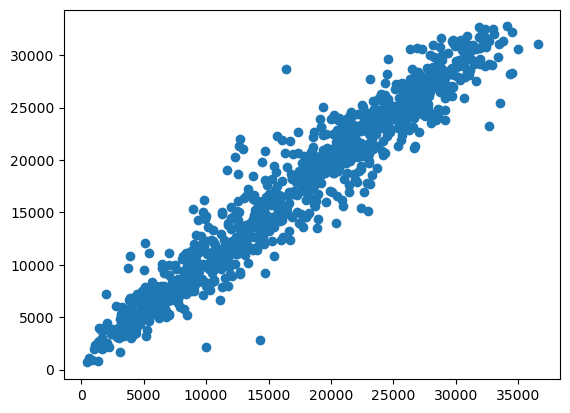

In [40]:
# view scatterplot with actual on x, predictions on y
# check for clustering around x=y
plt.scatter(x=val_df['counts'], y=val_df['y_pred'])

## Review test set (witheld months)

In [46]:
# build test df with predictions
test_df = df[withhold_range].copy()
test_df['y_pred'] = model.predict(test_df[X.columns])
test_df = test_df[['date','counts', 'y_pred']+list(X_train.columns)]
test_df_jan = test_df[test_df['date'].dt.month == 1]
test_df_aug = test_df[test_df['date'].dt.month == 8]

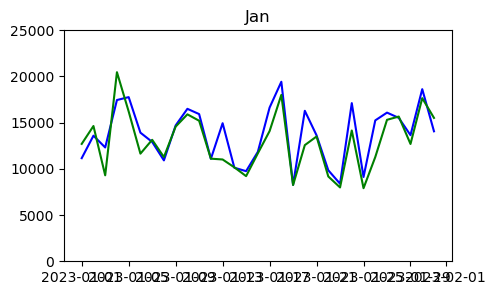

In [50]:
# plot january
x = test_df_jan['date']
y1 = test_df_jan['counts']
y2 = test_df_jan['y_pred']

plt.figure(figsize=(5, 3))
plt.plot(x, y1, color='blue')
plt.plot(x, y2, color='green')
plt.ylim(0,25000)
plt.title('Jan')
plt.show()

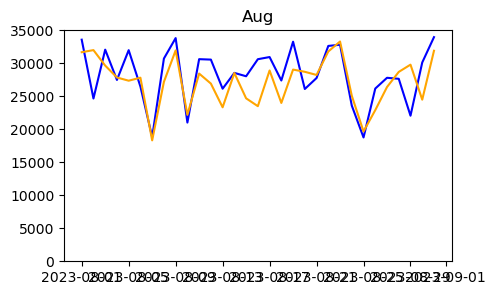

In [51]:
# plot august
x = test_df_aug['date']
y1 = test_df_aug['counts']
y2 = test_df_aug['y_pred']

plt.figure(figsize=(5, 3))
plt.plot(x, y1, color='blue')
plt.plot(x, y2, color='orange')
plt.ylim(0,35000)
plt.title('Aug')
plt.show()

## save xgb

In [54]:
with open('model/xgb_v1.pkl', 'wb') as f: # save model
    pickle.dump(model, f)

# also save the dates witheld for testing and feature input columns
with open('data/input_features.pkl', 'wb') as f:
    pickle.dump(X_train.columns, f)

# save test set for visualation
val_df.to_pickle('bike-prediction-app/data/val_df.pkl')
test_df = test_df.rename(columns={'counts':'actual', 'y_pred':'predicted'})
test_df.to_pickle('bike-prediction-app/data/test_df.pkl')

In [73]:
# get all performance metrics for display in app

y_train_pred = model.predict(X_train)
train_df = pd.DataFrame({'counts':y_train, 'y_pred':y_train_pred})
train_df['error'] = abs(train_df['y_pred']-train_df['counts'])
train_df['mape'] = train_df['error'] / train_df['counts'] * 100
train_mae = train_df['error'].mean()
train_mape = train_df['mape'].mean()
val_mae = val_df['error'].mean()
val_mape = val_df['perc_error'].mean() * 100
test_df['error'] = abs(test_df['predicted']-test_df['actual'])
test_mae = test_df['error'].mean()
test_df['mape'] = abs(test_df['predicted']-test_df['actual']) / test_df['actual'] * 100
test_mape = test_df['mape'].mean()

perf_dict = {
    'training MAE': np.round(train_mae,1),
    'validation MAE': np.round(val_mae,1),
    'test MAE': np.round(test_mae, 1),
    'training MAPE': np.round(train_mape, 1),
    'validation MAPE': np.round(val_mape, 1),
    'test MAPE': np.round(test_mape, 1)
}


In [75]:
# save
with open('bike-prediction-app/data/performance.pkl', 'wb') as f:
    pickle.dump(perf_dict, f)